In [10]:
import xarray as xr

import matplotlib.pyplot as plt

import colorcet as cc

import numpy as np

import scipy.stats as ss

from pathlib import Path
import ast
import intake
import intake_esm
from intake_esm import DerivedVariableRegistry

from computations import get_overlapping_time, rm_land, adjust_monthly_time, weighted_binned
import plotting_methods as plm

one difference between this script and `cam456_comparison_regimes.ipynb` is that one shows the satellite data directly,
and this one shows the difference/error from the satellite data. 

There's a bunch of code just to get the data loaded, and that is mostly shared with that notebook.

Then I'll add a section that will load the histogram error from files, and I guess merge that with the dicts holding the rest of the data.

For relative entropy, specify it as `<satellite>_relative_entropy`. Then when I load the "other" variables, I'll have a check for relative entropy that gets that particular satellite. Won't worry about generalizing for now, just assume we can do one at a time.

Note also that the relative entropy __time series__ are saved separately from the climatological versoin.

In [12]:
#
# IDENTIFY VARIABLES NEEDED HERE
#
variables_to_load = ['OMEGA500']  # ["clcalipso", "OMEGA500"]
other_variables = ['isccp_tseries_emd']   # ['modis_tseries_emd'] #  ["isccp_relative_entropy"]  # need to add "manually"
remove_land = True 


# def rm_land(dset, lf):
#     return xr.DataArray(np.where(lf <= 0, dset, np.nan), coords=dset.coords, dims=dset.dims, attrs=dset.attrs)

# Aux. data:
land = xr.load_dataset("/Users/brianpm/Dropbox/Data/cesm2_f09_land.nc")['LANDFRAC'].squeeze()
land60 = land.sel(lat=slice(-60,60))


if remove_land:
    rmlandstr = "noland"
else:
    rmlandstr = "withland"


# This is done during data loading now.
# for name in cat:
#     print(name)
#     sw = rm_land(cat[name]['SWCF'], land)
#     sw.name = "SWCF"
#     x = rm_land(cat[name][xvariable], land)
#     x.name = xvariable
#     cat[name] = xr.merge([sw, x])



# define colors for line plots
colorkey = {"CAM4": "#56B4E9",
           "CAM5": "#0072B2",
           "CAM6": "#E69F00",
           "E3SM": "#D55E00",
           "OBS": "#999999",
           "CALIPSO": "#999999",
           "CERES": "#999999"}


# Sets binning for each possible dynamic variable:
xbins = {"OMEGA500" : np.arange(-100, 110, 10),
         "LTS" : np.arange(0.5, 31.5, 1),
         "EIS" : np.arange(-5.5, 12.5, 0.5)}


# Catalogs & Derived Variable Registries
rootdir = Path("/Volumes/Drudonna/")
catsfils = {
    "CAM4": rootdir / "cam4_1deg_release_amip" / "catalog" / "catalog_cam4_1deg_release_amip.json",
    "CAM5": rootdir / "cam5_1deg_release_amip" / "catalog" / "catalog_cam5_1deg_release_amip.json",
    "CAM6": rootdir / "f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1" / "catalog" / "catalog_f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1.json",
    "E3SM": rootdir / "E3SM-1-0_amip" / "catalog" / "catalog_E3SM-1-0_amip.json",
    "OBS" : rootdir / "catalog_satellite_clouds_monthly.json"
}

# also define the derived variable registry:
dvr_objs = {"CAM4":DerivedVariableRegistry.load("CAM_derived_variable_registry"),
           "CAM5":DerivedVariableRegistry.load("CAM_derived_variable_registry"),
           "CAM6":DerivedVariableRegistry.load("CAM_derived_variable_registry"),
           "E3SM":DerivedVariableRegistry.load("e3sm_derived_variable_registry"),
           "OBS":None}
csv_kw = {"CAM4":None, "CAM5":None, "CAM6":None, "E3SM":None, "OBS":{"converters": {"variable": ast.literal_eval}}}

cats = {c: intake.open_esm_datastore(str(catsfils[c]), registry=dvr_objs[c], read_csv_kwargs=csv_kw[c]) for c in catsfils}


cats_subset = {}
for c in cats:
    if c == 'E3SM':
        cats_subset[c] = cats[c].search(variable=variables_to_load, member_id="r1i1p1f1")
    else:
        try:
            cats_subset[c] =  cats[c].search(variable=variables_to_load)
        except Exception:
            print(f"Sorry -- search failed for {c}")

#
# Loading the datasets
#
dsets = {}
for c in cats_subset:
    dcod = True if c == "OBS" else False
    tmp = cats_subset[c].to_dataset_dict(xarray_open_kwargs={"decode_times": dcod})
    if len(tmp.keys()) == 1:
        if c == 'OBS':
            dsets[list(tmp.keys())[0]] = tmp[list(tmp.keys())[0]]
        else:
            dsets[c] = tmp[list(tmp.keys())[0]] # call it CAM/E3SM
    elif c == 'E3SM':
        dsets[c] = xr.merge(tmp.values())
    else:
        dsets = {**dsets, **tmp} # adds ISCCP/MISR/MODIS as keys

timeslice = slice("2000-01-01","2020-12-31")

for dsn in dsets:
    if 'time_bnds' in dsets[dsn]:
        bnddim = [d != 'time' for d in dsets[dsn].time_bnds.dims].index(True)
        tmptime = dsets[dsn]['time_bnds'].mean(dim=dsets[dsn].time_bnds.dims[bnddim])
        tmptime.attrs = dsets[dsn]['time'].attrs
        dsets[dsn] = dsets[dsn].assign_coords({"time":tmptime})
        dsets[dsn] = xr.decode_cf(dsets[dsn])
    else:
        print(f"Did not find `time_bnds` in dataset {dsn}")

dsets = {c: dsets[c].sel(time=timeslice).load() for c in dsets}


#
# "Manual" changes to get other data into dicts
#
# -- Add ERA5 omega500 to observation data --
epath = "/Volumes/Drudonna/ERA5/remapped/era5_monthly_w500_1979-2020_unpack.nc" # put onto CAM grid same way as other data & dims renamed
with xr.open_dataset(epath) as eds:
    ew5 = eds['w']*864. 
    ew5.attrs['units'] = 'hPa d**-1'
    ew5.name = "OMEGA500"
    for src in set(cats['OBS'].df['source']):
        if src in dsets:
            select_times = dsets[src]["time"].dt.strftime("%Y-%m")
            ew5_srctime = ew5.sel(time=select_times) 
            assert np.all(ew5_srctime.lat == dsets[src]['lat']), "Lat mismatch"
            assert np.all(ew5_srctime.lon == dsets[src]['lon']), "Lon mismatch"
            ew5_srctime = ew5_srctime.assign_coords({'time':dsets[src]["time"]})
            dsets[src]['OMEGA500'] = ew5_srctime
        else:
            print(f"{src} is not in dsets, so will not add ERA5 OMEGA500 to it.")

if len(other_variables) > 0:
    for ov in other_variables:
        if "relative_entropy" in ov:
            textSearch = "relativeentropy"
            isDistVar = True
            fileVarName = 'relative_entropy'
            plotFileLabel = "Dkl"
        elif "emd" in ov:
            textSearch = "tseries_emd_nanversion"
            isDistVar = True
            fileVarName = 'EMD'
            plotFileLabel = "EMD"
        else:
            raise ValueError("Did not get a valid variable to add")
        if isDistVar:
            product_name = ov.split("_")[0] # format this string like <SATELLITE>_<DISTANCE METRIC>
            print(f"Trying to load {fileVarName} from {product_name}")
            loc = Path("/Users/brianpm/Dropbox/Projects/COSP2")
            for src in dsets:
                print(f"Just to be clear, {src = }")
                possible_matches = sorted(loc.glob(f"{src.lower()}_{product_name}_{textSearch}.nc"))
                if not possible_matches:
                    print(f"no matches for {src = }")
                else:
                    sel = possible_matches[-1]
                    print(f"SELECTING FILE: {sel}")
                    with xr.open_dataset(sel) as selds:
                        assert fileVarName in selds, f'Problem: did not find {fileVarName} in {sel}'
                        print(f"At load, number of non-missing values: {np.count_nonzero(~np.isnan(selds[fileVarName]))}")
                        compare_lat = np.all(dsets[src]['OMEGA500']['lat'].values == selds['lat'].values)
                        if not compare_lat:
                            lat_disagree = np.max(np.absolute(dsets[src]['OMEGA500']['lat'].values - selds['lat'].values))
                            print(f"LAT DISCREPANCY UP TO: {lat_disagree}")
                            if lat_disagree <= 1e-6:
                                print(f"Will reassign {fileVarName} latitude to OMEGA500 version")
                                selds = selds.assign_coords({"lat":dsets[src]['OMEGA500']['lat']})
                        compare_lon = np.all(dsets[src]['OMEGA500']['lon'].values == selds['lon'].values)
                        if not compare_lon:
                            lon_disagree = np.max(np.absolute(dsets[src]['OMEGA500']['lon'].values - selds['lon'].values))
                            print(f"LON DISCREPANCY UP TO: {lon_disagree}")
                            if lon_disagree <= 1e-6:
                                print(f"Will reassign {fileVarName} longitude to OMEGA500 version")
                                selds = selds.assign_coords({"lon":dsets[src]['OMEGA500']['lon']})
                        print(f"At the end, number of non-missing values: {np.count_nonzero(~np.isnan(selds[fileVarName]))}")
                        # in case of subsetting, check for overlapping time:
                        dstmp, selds = get_overlapping_time(dsets[src], selds)
                        selds = selds.assign_coords({"time":dstmp.time})
                        dsets[src] = dstmp
                        dsets[src][fileVarName] = selds[fileVarName]


# At this point, I want to make sure that OMEGA500 is in hPa/day and clcalipso is in PERCENT for all datasets
for d in dsets:
    if 'clcalipso' in dsets[d]:
        if dsets[d]['clcalipso'].max() < 2:
            dsets[d]['clcalipso'] *= 100.0
            dsets[d]['clcalipso'].attrs['units'] = 'percent'
            print(f"Adjusted clcalipso for {d}")
    if 'OMEGA500' in dsets[d]:
        if dsets[d]['OMEGA500'].max() < 10:
            print(f"inferring that OMEGA500 is in Pa/s ---> units says: {dsets[d]['OMEGA500'].attrs['units']}")
            if 'hPa' not in dsets[d]['OMEGA500'].attrs['units']:
                print("double checked and `hPa` not in units, so will transform")
                dsets[d]['OMEGA500'] *= 864.0
                dsets[d]['OMEGA500'].attrs['units'] = 'hPa d**-1'

## ALSO, for some reason altitude is the dimension name in CALIPSO, but not a coordinate variable, so fix that here
if "CALIPSO" in dsets:
    if 'altitude' not in dsets["CALIPSO"].coords:
        with xr.open_dataset("/Volumes/Drudonna/CALIPSO/GOCCP/3Ddata/remapped/fv09/3D_CloudFraction330m_200606_avg_CFMIP2_sat_3.1.2.nc") as exfile:
            dsets["CALIPSO"] = dsets["CALIPSO"].assign_coords({'altitude':exfile['alt_mid']})



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.stream.case'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.stream.case'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.stream.case'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.stream.case'


/var/folders/3y/4dzlw6yj5bj8ds39vpvyg92m0000gp/T/ipykernel_6450/186845822.py:87: UserWarning: There are no datasets to load! Returning an empty dictionary.
  tmp = cats_subset[c].to_dataset_dict(xarray_open_kwargs={"decode_times": dcod})


MODIS is not in dsets, so will not add ERA5 OMEGA500 to it.
CERES is not in dsets, so will not add ERA5 OMEGA500 to it.
CALIPSO is not in dsets, so will not add ERA5 OMEGA500 to it.
MISR is not in dsets, so will not add ERA5 OMEGA500 to it.
ISCCP is not in dsets, so will not add ERA5 OMEGA500 to it.
Trying to load EMD from isccp
Just to be clear, src = 'CAM4'
SELECTING FILE: /Users/brianpm/Dropbox/Projects/COSP2/cam4_isccp_tseries_emd_nanversion.nc
At load, number of non-missing values: 6235306
LAT DISCREPANCY UP TO: 1.4210854715202004e-14
Will reassign EMD latitude to OMEGA500 version
At the end, number of non-missing values: 6235306
Just to be clear, src = 'CAM5'
SELECTING FILE: /Users/brianpm/Dropbox/Projects/COSP2/cam5_isccp_tseries_emd_nanversion.nc
At load, number of non-missing values: 6137181
LAT DISCREPANCY UP TO: 1.4210854715202004e-14
Will reassign EMD latitude to OMEGA500 version
At the end, number of non-missing values: 6137181
Just to be clear, src = 'CAM6'
SELECTING FILE

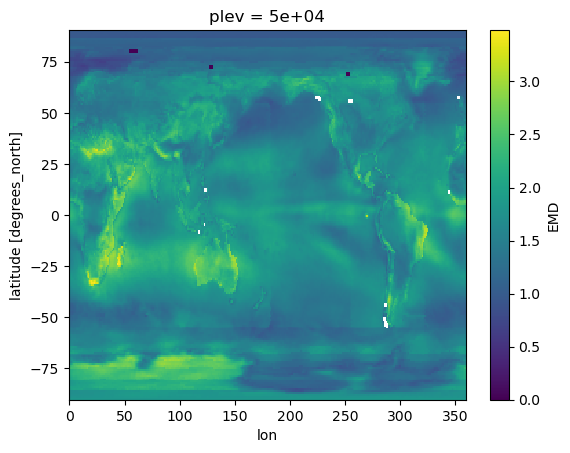

In [13]:
dsets['CAM4']['EMD'].mean(dim='time').plot.pcolormesh()

# np.count_nonzero(np.isnan(dsets['CAM4']['EMD']))

# dsets['CAM4'].coords

In [14]:
# Same as in histogram_error_by_omega500.ipynb


# def fix_cam_time(dset):
#     correct_time = dset['time_bnds'].mean(dim='nbnd').values
#     time = xr.DataArray(correct_time, dims=["time"], coords={"time":correct_time}, attrs=dset['time'].attrs)
#     dset = dset.assign_coords({"time":time})
#     dset = xr.decode_cf(dset)
#     return dset


def load_cam_ds(src, variable):
    # CLMODIS(time, cosp_prs, cosp_tau_modis, lat, lon) -- UNITS IN PERCENT
    if src == "CAM4":
        cam_ds = xr.open_dataset(
            f"/Volumes/Drudonna/cam4_1deg_release_amip/atm/proc/tseries/month_1/cam4_1deg_release_amip.cam.h0.{variable}.200011-201012.nc",
            decode_times=False,
        )
    elif src == "CAM5":
        cam_ds = xr.open_dataset(
            f"/Volumes/Drudonna/cam5_1deg_release_amip/atm/proc/tseries/month_1/cam5_1deg_release_amip.cam.h0.{variable}.200101-201012.nc",
            decode_times=False,
        )
    elif src == "CAM6":
        cam_ds = xr.open_dataset(
            f"/Volumes/Drudonna/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1/atm/proc/tseries/month_1/f.e21.FHIST_BGC.f09_f09_mg17.CMIP6-AMIP.001_cosp1.cam.h0.{variable}.197901-201412.nc",
            decode_times=False,
        )
    elif src == "E3SM":
        cam_ds = xr.open_dataset(f"/Volumes/Drudonna/E3SM-1-0_amip/remapped/")
    else:
        raise ValueError("Did not specify a valid version of CAM")
    cam_ds = adjust_monthly_time(cam_ds)
    return cam_ds[variable].load()



In [15]:
# remove land
if remove_land:
    for d in dsets:
        for v in dsets[d]:
            if hasattr(dsets[d][v], 'lat'):
                dsets[d][v] = rm_land(dsets[d][v], land)

# Constrain to 60S to 60N
latslice = slice(-60, 60)
for d in dsets:
    for v in dsets[d]:
        if hasattr(dsets[d][v], 'lat'):
            dsets[d][v] = dsets[d][v].sel(lat=latslice)

[rm_land] Latitudes mismatch. Largest discrepancy is 1.4210854715202004e-14 degrees.
[rm_land] Latitudes mismatch. Largest discrepancy is 1.4210854715202004e-14 degrees.
[rm_land] Latitudes mismatch. Largest discrepancy is 1.4210854715202004e-14 degrees.
[rm_land] Latitudes mismatch. Largest discrepancy is 1.4210854715202004e-14 degrees.


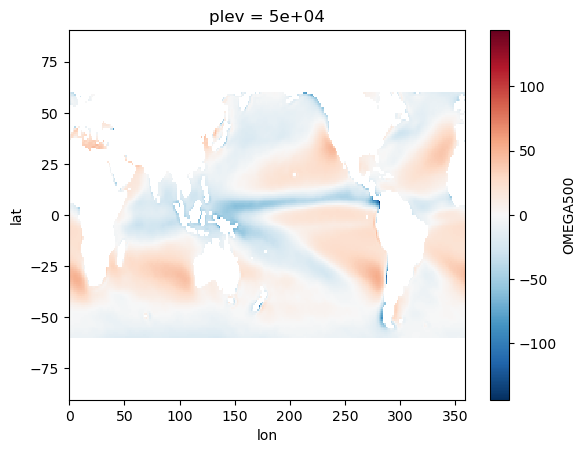

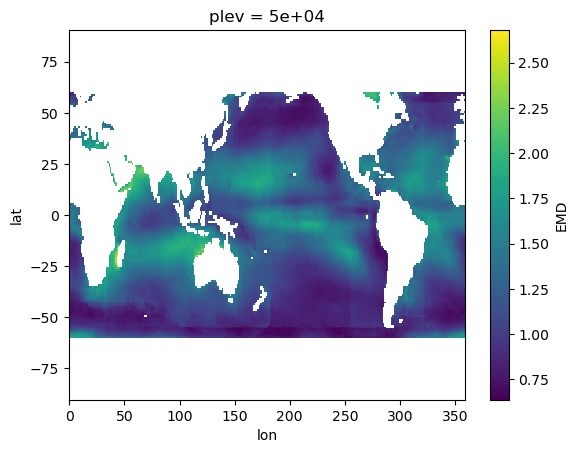

In [16]:
dsets['CAM5']['OMEGA500'].mean(dim='time').plot.pcolormesh()
plt.show()
dsets['CAM5'][fileVarName].mean(dim='time').plot.pcolormesh()


In [17]:
# MOVED THIS FUNCTION TO computations
# def weighted_binned(x, y, bins):
#     """Binned statistic weighted by cos(lat)."""
#     wgt = np.cos(np.radians(x['lat']))
#     wgt_array = wgt.broadcast_like(x)
#     # wherever the data is invalid, weight should be set to zero:
#     wgt_array = xr.where(np.logical_or(np.isnan(x), np.isnan(y)), 0, wgt_array)
#     # first get the sum of weights in each bin
#     wgt_bs, wgt_edg, wgt_num = ss.binned_statistic(x.values.flatten(), wgt_array.values.flatten(), statistic=np.nansum, bins=bins)
#     # next get the sum of wgt_array * y
#     wy_bs, wy_edg, wy_num = ss.binned_statistic(x.values.flatten(), (y*wgt_array).values.flatten(), statistic=np.nansum, bins=bins)
#     # calculate the average by dividing by the sum of weights
#     return wy_bs/wgt_bs, wy_edg, wy_num


regions = {"global":slice(-90,90),  # **NOTE dsets IS ALREADY CONSTAINED TO 60S-60N**
          "tropics":slice(-30,30),
          "socean":slice(-90,-30)}  # try -45 instead of -30  

# Now do the sampling
omega_bins = np.linspace(-100, 100, 41)
binned = {}
binned_std = {}
binned_num = {}
for region in regions:
    binned[region] = {}
    binned_std[region] = {}
    binned_num[region] = {}
    for name in dsets:
        if ('OMEGA500' in dsets[name]) and (fileVarName in dsets[name]):
            wtmp = dsets[name]['OMEGA500'].sel(lat=regions[region])
            ytmp = dsets[name][fileVarName].sel(lat=regions[region]) # EMD or relative_entropy
            # y_bs, edg, num = ss.binned_statistic(wtmp.values.flatten(), ytmp.values.flatten(), statistic=np.nanmean, bins=omega_bins)
            # z_bs, _, _ = ss.binned_statistic(wtmp.values.flatten(), ytmp.values.flatten(), statistic=np.nanstd, bins=omega_bins)
            y_bs, edg, num = weighted_binned(wtmp, ytmp, omega_bins)
            binned[region][name] = y_bs
            binned_num[region][name] = num
            # binned_std[region][name] = z_bs
            # Bin center
            bctr = edg[0:-1] + 0.5*np.diff(edg)
        else:
            print(f"skipping {name}")
        
# rebinned = stats.binned_statistic(cam_w500.values.flatten(), rel_ent.values.flatten(), statistic=np.nanmean, bins=omega_bins)
# bin_centers = rebinned.bin_edges[0:-1] + 0.5*np.diff(rebinned.bin_edges)

IMPORTED SS!
IMPORTED SS!
IMPORTED SS!
IMPORTED SS!
IMPORTED SS!
IMPORTED SS!
IMPORTED SS!
IMPORTED SS!
IMPORTED SS!
IMPORTED SS!
IMPORTED SS!
IMPORTED SS!


0
global
CAM4
CAM5
CAM6
E3SM
1
tropics
CAM4
CAM5
CAM6
E3SM
2
socean
CAM4
CAM5
CAM6
E3SM
output file: /Users/brianpm/Dropbox/Apps/Overleaf/cam_clouds_generations/Figures/cam456_isccp_EMD_by_omega500.pdf
File already exists ... specify whether to overwrite: True.


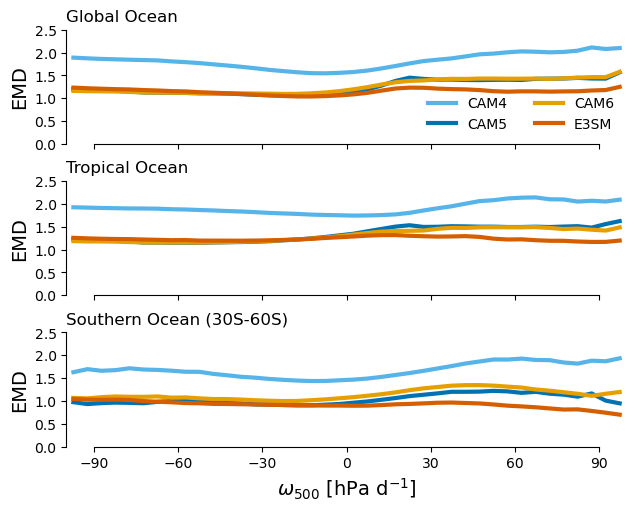

In [27]:
regionkey = {"global": "GLOBAL OCEAN",
          "tropics": "TROPICAL OCEAN",
          "socean": f"SOUTHERN OCEAN ({np.absolute(regions['socean'].stop)}S-60S)"}  # try -45 instead of -30


# if this were a separate function to make the plot
# we'd need input:
# binned -> dict of regions, which are dict of x(bins)
# nregions = len(regions) = len(binned) ?
# bctr : bin centers
# colorkey : dict of colors based on label
# regionkey : dict of strings based on label

fig, ax = plt.subplots(figsize=(6.25,5), nrows=len(regions), sharex=True, constrained_layout=True)
a = ax.ravel()
for i, r in enumerate(regions):
    print(i)
    print(r)
    for j, b in enumerate(binned[r]):
        print(b)
        a[i].plot(bctr, binned[r][b], label=b, color=colorkey[b], linewidth=3, clip_on=False)
        # a[i].fill_between(bctr, binned[r][b]-binned_std[r][b], binned[r][b]+binned_std[r][b], alpha=0.5, color=colorkey[b], clip_on=False)

    a[i].set_title(regionkey[r].title(), loc='left')
ax[-1].set_xlabel("$\omega_{500}$ [hPa d$^{-1}$]", fontsize=14)
if fileVarName == "relative_entropy":
    [a.set_ylabel("$\mathcal{D}_{\mathrm{KL}}$", fontsize=14) for a in ax]
elif fileVarName == "EMD":
    [a.set_ylabel("EMD", fontsize=14) for a in ax]
[a.set_xlim([-100, 100]) for a in ax]
ax[0].legend(ncol=2, frameon=False)


[a.spines['top'].set_visible(False) for a in ax]
[a.spines['right'].set_visible(False) for a in ax]
[a.set_xticks([-90, -60, -30, 0, 30, 60, 90]) for a in ax]
[a.spines.bottom.set_bounds((-90, 90)) for a in ax]

yupper = 2.5
dytick = 0.5
[a.set_ylim([0, yupper]) for a in ax]
[a.set_yticks(np.arange(0, yupper+dytick, dytick)) for a in ax]
[a.spines.left.set_bounds((0, yupper)) for a in ax]


plotfilename = f"/Users/brianpm/Dropbox/Apps/Overleaf/cam_clouds_generations/Figures/cam456_{product_name}_{plotFileLabel}_by_omega500.pdf"
print(f"output file: {plotfilename}")
plm.fig_output(fig, plotfilename, clobber_fig=True)